# Main results: presentation of the model and the proof of its validity
Tuning curves prediction and position decoding from firing rates.

- a. Schematic of the model
- b. Examples of tunign curves pre and post alignment
- c. Quantify the similarity of the tuning curves after alignment
- d. Show the performance of the decoders built on one session and used across

In [1]:
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.sys.path.append(parent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_n_recordings, smooth_tuning_curves_circularly
from tools.data_manager import get_all_experiments_runs
from tools.alignment import procrustes, canoncorr
from global_vars import order_experiments

## Fig.1.a

In [12]:
### Load all sessions ###

animal = 'm120'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

Concatenated tuning curves shape: (2520, 138)


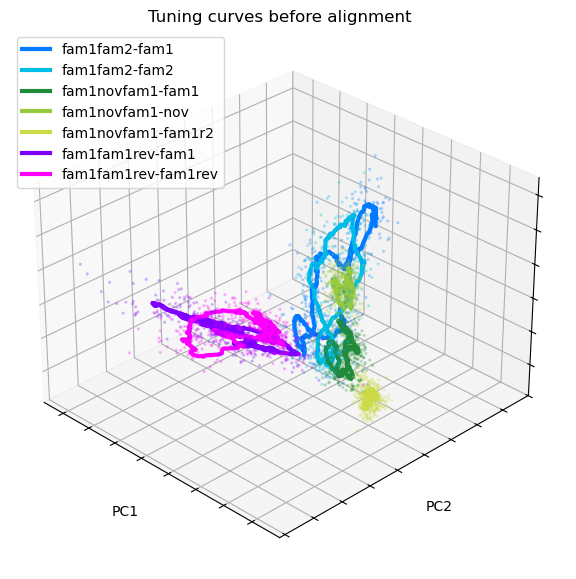

In [14]:
# Get the common cells and order all the tuning curves accordingly
sel_cells_masks, ordered_cells = get_common_indexes_n_recordings(all_cells)
# Remove the cells that are not common to all recordings
sel_tuning_curves = [tuning_curves[:, mask] for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)]
# Order all the cells such that indexes correspond to the same cell across all recordings
sel_tuning_curves = [tuning_curves[:, order] for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)]

# Concatenate all the tuning curves
concatenated_tuning_curves = np.concatenate(sel_tuning_curves, axis=0)
print(f'Concatenated tuning curves shape: {concatenated_tuning_curves.shape}')

# Perform PCA on the concatenated tuning curves
pca = PCA()
pca_conc_tuning_curves = pca.fit_transform(concatenated_tuning_curves)
# Split the recordings again into separate sessions
pca_tuning_curves = np.split(pca_conc_tuning_curves, len(sel_tuning_curves), axis=0)

# Smooth the tuning curves
smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 20) for tuning_curves in pca_tuning_curves]

colors = ["#007bff", "#00bde8", 
          "#208b3a", "#99ca3c", "#cbdb47", 
          "#8000ff", "#ff00ff"]
# # Plot them
# fig = go.Figure()
# for i in range(len(smoothed_tuning_curves)):
#     fig.add_trace(go.Scatter3d(x=pca_tuning_curves[i][:, 0], y=pca_tuning_curves[i][:, 1], z=pca_tuning_curves[i][:, 2], 
#                                mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2), showlegend=False))
#     fig.add_trace(go.Scatter3d(x=smoothed_tuning_curves[i][:, 0], y=smoothed_tuning_curves[i][:, 1], z=smoothed_tuning_curves[i][:, 2], 
#                                mode='lines', line=dict(color=colors[i], width=5), name=f'{sessions[i][0]}-{sessions[i][1]}'))

# fig.update_layout(title='Tuning curves before alignment')
# fig.show()

# Plot a static version
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(smoothed_tuning_curves)):
    ax.scatter(pca_tuning_curves[i][:, 0], pca_tuning_curves[i][:, 1], pca_tuning_curves[i][:, 2], color=colors[i], alpha=0.2, s=2)
    ax.plot(smoothed_tuning_curves[i][:, 0], smoothed_tuning_curves[i][:, 1], smoothed_tuning_curves[i][:, 2], color=colors[i], linewidth=3, label=f'{sessions[i][0]}-{sessions[i][1]}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# Rotate the view (set azimuth and elevation)
ax.view_init(azim=135, elev=30)
ax.set_title('Tuning curves before alignment')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend()
plt.show()


IndexError: list index out of range

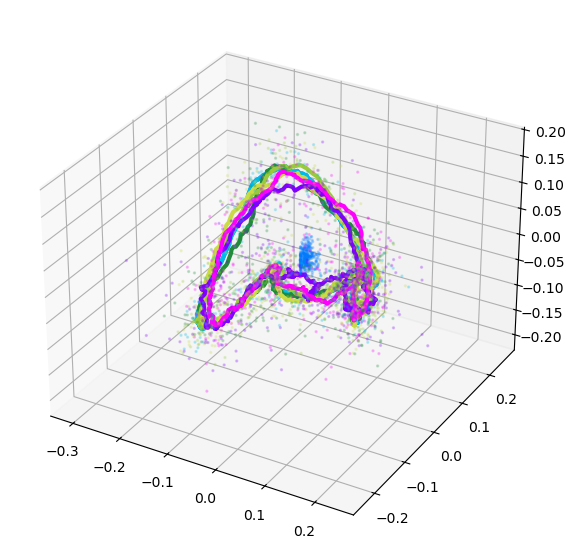

In [6]:
# I think I should plot only 2 sessions aligned, because otherwise the common neurons are very little 
# I should keep doing CCA pairwise (or procrustes) for this reason, so I don't have to select common neurons

# Take as a reference the first session 
ref_experiment, ref_run = sessions[0]
ref_tuning_curves = all_tuning_curves[0]
ref_cells = all_cells[0]
pca = PCA(n_components=20)
pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)

# Variables to save the embeddings
all_d = []
all_tform = []
all_tuning_curves_transformed = []
for i, (experiment, run) in enumerate(sessions[1:]):
        tuning_curves = all_tuning_curves[i]
        pca_tuning_curves = pca.fit_transform(tuning_curves)
        A, B, r, _, cca_tuning_curves = canoncorr(pca_ref_tuning_curves, pca_tuning_curves, fullReturn=True)
        all_tuning_curves_transformed.append(cca_tuning_curves @ np.linalg.inv(A))
# Save their smoothed version
all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]
ref_smoothed_tuning_curves = smooth_tuning_curves_circularly(pca_ref_tuning_curves, kernel_size=20)

# Plot the aligned tuning curves
colors = ["#007bff", "#00bde8", 
          "#208b3a", "#99ca3c", "#cbdb47", 
          "#8000ff", "#ff00ff"]
# fig = go.Figure()
# # Add the reference trace
# fig.add_trace(go.Scatter3d(x=ref_smoothed_tuning_curves[:, 0], y=ref_smoothed_tuning_curves[:, 1], z=ref_smoothed_tuning_curves[:, 2],
#                            mode='lines', line=dict(color=colors[0], width=5), name=f'{ref_experiment}-{ref_run}'))
# # Add al the aothers
# for i in range(len(all_tuning_curves_transformed)):
#     fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
#                                mode='markers', marker=dict(size=2, color=colors[i+1], opacity=0.2), showlegend=False))
#     fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
#                                mode='lines', line=dict(color=colors[i+1], width=5), name=f'{sessions[i+1][0]}-{sessions[i+1][1]}'))
# # Add title
# fig.update_layout(title='Tuning curves after alignment')
# fig.show()

# Plot a static version
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
# Add the reference trace
ax.scatter(ref_tuning_curves[:, 0], ref_tuning_curves[:, 1], ref_tuning_curves[:, 2], color=colors[0], alpha=0.2, s=2)
ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color=colors[0], linewidth=3, label=f'{ref_experiment}-{ref_run}')
# Add al the aothers
for i in range(len(all_tuning_curves_transformed)):
    ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], color=colors[i+1], alpha=0.2, s=2)
    ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color=colors[i+1], linewidth=3, label=f'{sessions[i+1][0]}-{sessions[i+1][1]}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# Rotate the view (set azimuth and elevation)
ax.view_init(azim=135, elev=30)
ax.set_title('Tuning curves after alignment - CCA')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend()
plt.show()

In [4]:
# Take as a reference the first session 
ref_experiment, ref_run = sessions[0]
ref_tuning_curves = all_tuning_curves[0]
ref_cells = all_cells[0]
pca = PCA(n_components=20)
pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)

# Variables to save the embeddings
all_d = []
all_tform = []
all_tuning_curves_transformed = []
for i, (experiment, run) in enumerate(sessions[1:]):
        tuning_curves = all_tuning_curves[i]
        pca_tuning_curves = pca.fit_transform(tuning_curves)
        d, pca_tuning_curves_transformed, tform = procrustes(pca_ref_tuning_curves, pca_tuning_curves)
        all_d.append(d)
        all_tform.append(tform)
        all_tuning_curves_transformed.append(pca_tuning_curves_transformed)
# Save their smoothed version
all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]

# Plot the aligned tuning curves
colors = ["#007bff", "#00bde8", 
          "#208b3a", "#99ca3c", "#cbdb47", 
          "#8000ff", "#ff00ff"]
# fig = go.Figure()
# for i in range(len(all_tuning_curves_transformed)):
#     fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
#                                mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2)))
#     fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
#                                mode='lines', line=dict(color=colors[i], width=3)))
# fig.show()

# Plot a static version
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
# Add the reference trace
ax.scatter(ref_tuning_curves[:, 0], ref_tuning_curves[:, 1], ref_tuning_curves[:, 2], color=colors[0], alpha=0.2, s=2)
ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color=colors[0], linewidth=3, label=f'{ref_experiment}-{ref_run}')
# Add al the aothers
for i in range(len(all_tuning_curves_transformed)):
    ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], color=colors[i+1], alpha=0.2, s=2)
    ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color=colors[i+1], linewidth=3, label=f'{sessions[i+1][0]}-{sessions[i+1][1]}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# Rotate the view (set azimuth and elevation)
ax.view_init(azim=135, elev=30)
ax.set_title('Tuning curves after alignment - Procrustes')
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.legend()
plt.show()

NameError: name 'sessions' is not defined

## Fig.2.b 

In [7]:
# Load data


Runs: fam1novfam1 fam1 - fam1novfam1 fam1r2
Shape tuning_curves: (360, 186) - (360, 186)
